In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    TextVectorization, 
    Embedding, 
    Dense, 
    Dropout, 
    Bidirectional,
    LSTM
)
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import requests
import zipfile

In [23]:
# BUILD BASIC RNN

In [ ]:
DATA = '../../Data/Specialty-Data/specialty_data.csv'
MAPPINGS = '../../Data/Specialty-Data/specialty_data_label_mappings.json'
FEATURE = 'transcription'

# Constants to configure RNN
VOCAB_SIZE = 10000
# 512 Tokens
MAX_SEQUENCE_LENGTH = 512
VECTOR_SIZE = 128
EPOCHS = 20
BATCH_SIZE = 32

In [25]:
# Retrieve data and build respective train/test/validate datasets

try:
    df = pd.read_csv(DATA)
    with open(MAPPINGS, 'r') as f:
        mappings = json.load(f)
    
    id_to_label = {int(k): v for k, v in mappings['id_to_label'].items()}
    label_names = [id_to_label[i] for i in range(len(id_to_label))]
    NUM_CLASSES = len(label_names)

except:
    print(f"Data not found, make sure to run the specialty_data_preprocessing.ipynb file in its entirety to retrieve the data")

texts = df[FEATURE].values
labels = df['label'].values

# 1 / 10 = 0.1
X_train_val, X_test, y_train_val, y_test = train_test_split(
    texts, labels, test_size=0.1, stratify=labels, random_state=0
)

# 1 / 9 = 0.111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.111, stratify=y_train_val, random_state=0
)

print(f"Total samples: {len(texts)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {NUM_CLASSES}")

Total samples: 1263
Training samples: 1009
Validation samples: 127
Test samples: 127
Number of classes: 5


In [32]:
# Design layers of RNN

# Configure vectorization layer for how it should take in and tokenize text
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Build vectors to encode words based on vocabulary in training dataset
vectorize_layer.adapt(X_train)

# print(vectorize_layer.get_vocabulary()[:20])

# Look up training vector based on token
embedding_layer = Embedding(
    VOCAB_SIZE,
    VECTOR_SIZE,
    name="embedding",
    mask_zero=True
)

# Build RNN with layers here
model = Sequential([
    # Input layer
    tf.keras.Input(shape=(1,), dtype=tf.string),
    # Vectorization layer
    vectorize_layer,
    # Embedding layer
    embedding_layer,

    # Read text from both directions
    # Changed to slightly more layered approach
    # Bidirectional(LSTM(64)),

    Bidirectional(LSTM(
        64, 
        recurrent_dropout=0.2, 
        return_sequences=True
    )),
    Bidirectional(LSTM(
        64, 
        recurrent_dropout=0.2
    )),

    # Feed forward network to mix features
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output probabilities for each class
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# End training if validation loss is not decreasing
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_13           │ (None, 512)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 512, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 512, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,213 (5.67 MB)

 Trainable params: 1,486,213 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.2934 - loss: 1.5519 - val_accuracy: 0.3543 - val_loss: 1.3782
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4450 - loss: 1.3253 - val_accuracy: 0.5197 - val_loss: 1.1655
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6432 - loss: 0.9484 - val_accuracy: 0.7244 - val_loss: 0.8053
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7810 - loss: 0.6381 - val_accuracy: 0.7323 - val_loss: 0.7564
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8147 - loss: 0.5202 - val_accuracy: 0.7165 - val_loss: 0.7870
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8424 - loss: 0.4272 - val_accuracy: 0.7008 - val_loss: 0.8341
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8553 - loss: 0.3707 - val_accuracy: 0.6929 - val_loss: 0.9477
Evaluating on test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step - accuracy: 0.6929 - loss: 0.8907
Test Accuracy: 69.

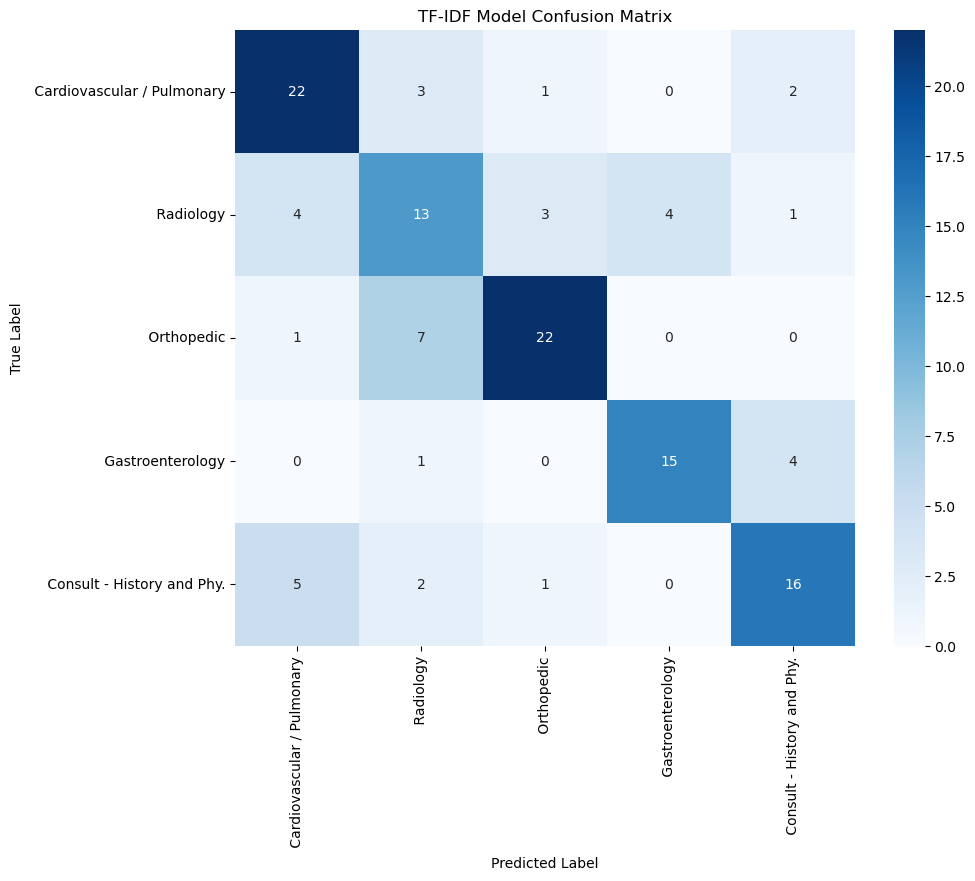

In [33]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)

# Test the model
print(f"Evaluating on test set")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# How well did each area get classified
report = classification_report(y_test, y_pred, target_names=label_names)
print(f"Classification Report")
print(report)

# Confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RNN Model Confusion Matrix')
# plt.savefig("rnn_confusion_matrix.png")

In [ ]:
# BUILD RNN WITH ADDITIONAL VOCABULARY

In [36]:
DATA = '../../Data/Specialty-Data/specialty_data.csv'
MAPPINGS = '../../Data/Specialty-Data/specialty_data_label_mappings.json'
FEATURE = 'transcription'

# Constants to configure RNN
VOCAB_SIZE = 10000
# 512 Tokens
MAX_SEQUENCE_LENGTH = 512
VECTOR_SIZE = 300
EPOCHS = 20
BATCH_SIZE = 32

In [37]:
# Retrieve data and build respective train/test/validate datasets

try:
    df = pd.read_csv(DATA)
    with open(MAPPINGS, 'r') as f:
        mappings = json.load(f)
    
    id_to_label = {int(k): v for k, v in mappings['id_to_label'].items()}
    label_names = [id_to_label[i] for i in range(len(id_to_label))]
    NUM_CLASSES = len(label_names)

except:
    print(f"Data not found, make sure to run the specialty_data_preprocessing.ipynb file in its entirety to retrieve the data")

texts = df[FEATURE].values
labels = df['label'].values

# 1 / 10 = 0.1
X_train_val, X_test, y_train_val, y_test = train_test_split(
    texts, labels, test_size=0.1, stratify=labels, random_state=0
)

# 1 / 9 = 0.111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.111, stratify=y_train_val, random_state=0
)

print(f"Total samples: {len(texts)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {NUM_CLASSES}")

Total samples: 1263
Training samples: 1009
Validation samples: 127
Test samples: 127
Number of classes: 5


In [ ]:
# Download the vocabulary dataset to use for this next RNN model

URL = "https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip"
DATA_DIRECTORY = "../../Data/Specialty-Data"
DOWNLOADED_ZIP = os.path.join(DATA_DIRECTORY, "glove.2024.wikigiga.300d.zip")
GLOVE_PATH = os.path.join(DATA_DIRECTORY, "wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt")

if os.path.exists(GLOVE_PATH):
    print(f"Dataset already exists at {GLOVE_PATH}")
else:
    print(f"Downloading dataset to {DOWNLOADED_ZIP}, this will take a bit, roughly 1.1gb zip download")

    with requests.get(URL, stream=True) as r:
        r.raise_for_status()
        with open(DOWNLOADED_ZIP, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print(f"Downloaded to {DOWNLOADED_ZIP}")

    print("-------------------------------------")

    print("Extracting zip, this will take a bit of time to unpack")

    with zipfile.ZipFile(DOWNLOADED_ZIP, "r") as zip_ref:
        zip_ref.extractall(DATA_DIRECTORY)

    print(f"Files extracted to: {DATA_DIRECTORY}")

    os.remove(DOWNLOADED_ZIP)

    print("Zip removed")

Downloaded to ../../Data/Specialty-Data\glove.2024.wikigiga.300d.zip
-------------------------------------
Extracting zip, this will take a bit of time to unpack
Files extracted to: ../../Data/Specialty-Data
Zip removed


In [ ]:
# Gonna prebuild vocabulary to try to improve RNN model 

print(f"Prebuild vocabulary with GloVe dataset, this will take a bit")

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

vectorize_layer.adapt(X_train)
vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embeddings_index = {}
try:
    with open(GLOVE_PATH, encoding='utf8') as f:
        for line in f:
            word, coefs_string = line.split(maxsplit=1)
            coefs = np.fromstring(coefs_string, "f", sep=" ")

            # Many vectors missing 300 dimensionality, ignore those that do not
            if coefs.shape[0] == VECTOR_SIZE:
                embeddings_index[word] = coefs
            else:
                # print(f"Skipping word that has improper dimensionality: {word}") 
                pass
except:
    print(f"GloVe not found, make sure to do the downloading from the previous code block")

print(f"Found {len(embeddings_index)} vectors.")

C:\Users\spenc\AppData\Local\Temp\ipykernel_30260\1020342042.py:17: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs_string, "f", sep=" ")


Found 1287614 vectors.


In [41]:
num_tokens = len(vocabulary)
hits = 0
misses = 0

# Create embedding matrix to give the model a solid foundation
embedding_matrix = np.zeros((num_tokens, VECTOR_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words and {misses} misses")

# Look up training vector based on token
embedding_layer = Embedding(
    num_tokens,
    VECTOR_SIZE,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    # False = Lock weights, True = Unlock all weights
    trainable=False,
    name="embedding"
)

# Build RNN with layers here
model = Sequential([
    # Input layer
    tf.keras.Input(shape=(1,), dtype=tf.string),
    # Vectorization layer
    vectorize_layer,
    # Embedding layer
    embedding_layer,
    # Read text from both directions
    Bidirectional(LSTM(64)),
    # Feed forward network to mix features
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output probabilities for each class
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# End training if validation loss is not decreasing
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

Converted 7966 words (2034 misses)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_15           │ (None, 512)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 512, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,195,461 (12.19 MB)

 Trainable params: 195,461 (763.52 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 711ms/step - accuracy: 0.4093 - loss: 1.4352 - val_accuracy: 0.4803 - val_loss: 1.2294
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step - accuracy: 0.6214 - loss: 1.0467 - val_accuracy: 0.6535 - val_loss: 0.9854
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 704ms/step - accuracy: 0.6947 - loss: 0.8353 - val_accuracy: 0.6850 - val_loss: 0.8411
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 700ms/step - accuracy: 0.7037 - loss: 0.7426 - val_accuracy: 0.6850 - val_loss: 0.7737
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 704ms/step - accuracy: 0.7592 - loss: 0.6222 - val_accuracy: 0.7244 - val_loss: 0.7131
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 701ms/step - accuracy: 0.7810 - loss: 0.5489 - val_accuracy: 0.7323 - val_loss: 0.7384
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 698ms/step - accuracy: 0.8048 - loss: 0.4992 - val_accuracy: 0.7087 - val_loss: 0.7161
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 684ms/step - accuracy: 0.8018 - loss: 0.4994 - val_accu

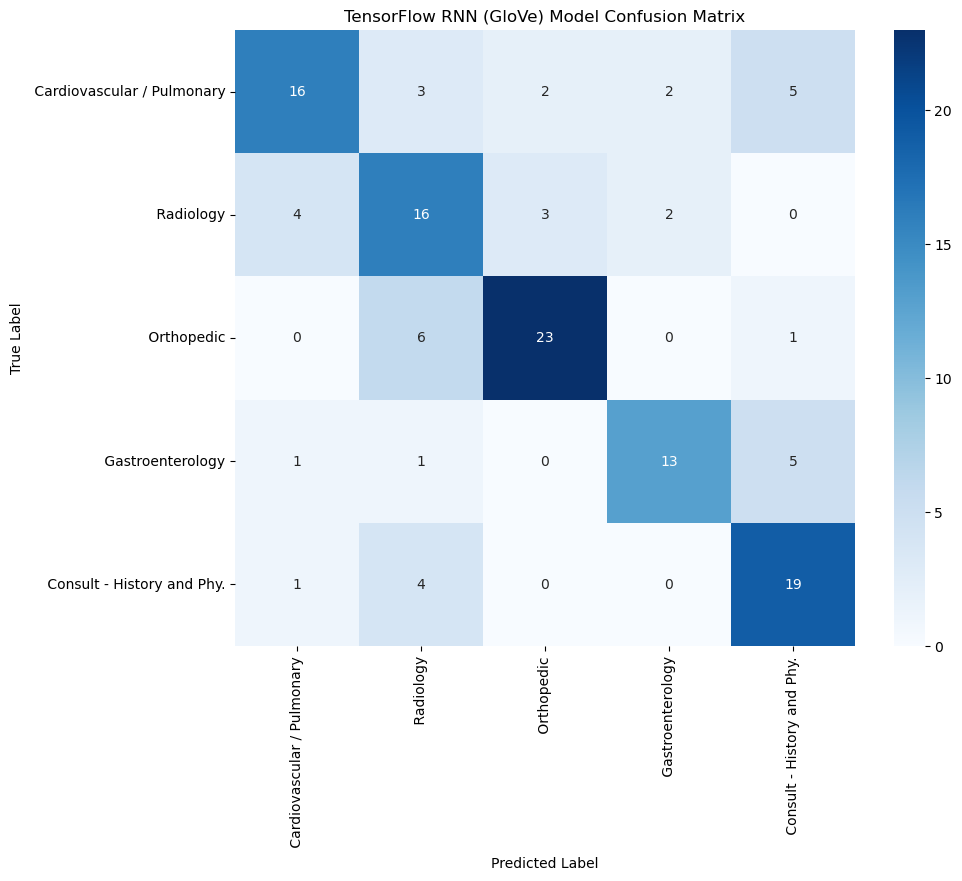

In [42]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)

# Test the model
print(f"Evaluating on test set")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# How well did each area get classified
report = classification_report(y_test, y_pred, target_names=label_names)
print(f"Classification Report")
print(report)

# Confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TensorFlow RNN (GloVe) Model Confusion Matrix')
# plt.savefig("rnn_glove_confusion_matrix.png")
# print("Confusion matrix saved to rnn_glove_confusion_matrix.png")